CIFAR10 dataset split into neg/pos and trained using Resnet50 without augmentation.  
- Class weighting  
- Resampling  
- Initial Bias-estimation
- Decreasing learning rate

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/train/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "model": 'resnet50',
    "ds_info": 'binary',
    "resample": False,
    "neg_class": ['ship'],
    "num_epochs": 100,
    "batch_size": 128,
    "img_shape": (32, 32, 3),
    "outcast": None,
    "optimizer": 'Adam',
    "final_activation": 'sigmoid',
    "learning_rate": 0.001,
    "early_stopping_patience": 10,
    "decay_rate": 0.4,              # higher number gives steeper dropoff
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

learning_rate = config["learning_rate"]
fine_tune_at = 130
fine_tune_epochs = 150
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]

neg = params["neg_count"]
pos = params["pos_count"]
total = params["ds_size"]

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 1 0 1]
[1 1 1 1 1 1 0 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 0 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1]

Full dataset sample size:        50000
Train dataset sample size:       35000
Test dataset sample size:         7500
Validation dataset sample size:   7500


# Training

### Resnet50 transfer learning
see https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
imbalanced-data: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

import datetime

In [5]:
metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
]

In [6]:
res_net = tf.keras.applications.ResNet50(
                weights='imagenet', 
                include_top=False, 
                input_shape=config["img_shape"])

res_net.trainable = True

In [7]:
def make_model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    global_average_layer = GlobalAveragePooling2D()
    output_layer = Dense(1, activation='sigmoid',
                         bias_initializer=output_bias)

    resnet50_model = tf.keras.Sequential([
            res_net,
            global_average_layer,
            output_layer])
    
    if config['optimizer'] == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif config['optimizer'] == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    resnet50_model.compile(
            optimizer=opt,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=metrics)
    
    return resnet50_model

### Callbacks

In [8]:
initial_learning_rate = learning_rate
decay_steps = train_steps
batch_size = config['batch_size']
decay_rate = config['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(config["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss',verbose=1, patience=early_stopping_patience, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb, earlystopp_cb, lr_schedule_cb]

# Write config dictionary to text file
f = open(log_dir+"/config.txt","w")
f.write( str(config) )
f.close()

## Set correct initial bias


In [9]:
bias_model = make_model()

# Test run the model and show 10 first predictions of one epoch
bias_model.predict(train_ds.take(1))[:10]

array([[0.761696  ],
       [0.7908592 ],
       [0.7503537 ],
       [0.8157922 ],
       [0.82378453],
       [0.7997958 ],
       [0.7941746 ],
       [0.7170031 ],
       [0.73868924],
       [0.8094598 ]], dtype=float32)

In [10]:
results = bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3825


In [11]:
initial_bias = np.log([pos/neg])
print ("The initial bias should then be: {:.4f}".format(initial_bias[0]))

The initial bias should then be: 2.1972


In [12]:
new_bias_model = make_model(output_bias = initial_bias)
new_bias_model.predict(train_ds, verbose=0, steps=train_steps)

print ("Initial guess should be around:", pos/total)
new_bias_model.predict(train_ds.take(1))[:10]

Initial guess should be around: 0.9


array([[0.28596872],
       [0.2812585 ],
       [0.34275562],
       [0.34957856],
       [0.31746656],
       [0.31804055],
       [0.3059333 ],
       [0.30887285],
       [0.2606473 ],
       [0.3275812 ]], dtype=float32)

In [13]:
results = new_bias_model.evaluate(train_ds, verbose=0, steps=train_steps)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0849


In [14]:
initial_weights = os.path.join(log_dir,'initial_weights')
new_bias_model.save_weights(initial_weights)

#### Confirm that the bias fix helps

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

## Baseline

In [16]:
baseline_model = make_model()
baseline_model.load_weights(initial_weights)

baseline_history = baseline_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 273 steps, validate for 58 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
273/273 [==============================] - 28s 103ms/step - loss: 0.1401 - tp: 30976.0000 - fp: 1247.0000 - tn: 2251.0000 - fn: 470.0000 - accuracy: 0.9509 - precision: 0.9613 - recall: 0.9851 - auc: 0.9582 - val_loss: 0.3335 - val_tp: 6683.0000 - val_fp: 741.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.9002 - val_precision: 0.9002 - val_recall: 1.0000 - val_auc: 0.7559

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008420727945712524.
Epoch 2/100
273/273 [==============================] - 16s 59ms/step - loss: 0.0702 - tp: 31094.0000 - fp: 578.0000 - tn: 2917.0000 - fn: 355.0000 - accuracy: 0.9733 - precision: 0.9818 - recall: 0.9887 - auc: 0.9877 - val_loss: 0.8923 - val_tp: 6680.0000 - val_fp: 744.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8998 - val_precision: 0.8998 - val_recall: 1.0000 - val_auc: 0.

`Keras`
Save/load the model

In [17]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

#### Validate the results

In [18]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

Some functions

In [19]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(12, 10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

In [20]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    
    metrics_list = np.asarray([['tn', 'fp'], ['fn', 'tp']])
    labels = (np.asarray(["{0}\n{1:.0f}".format(metrics_list,cm) for metrics_list, cm in zip(metrics_list.flatten(), cm.flatten())])).reshape(2,2)
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=labels, fmt="", robust=True, annot_kws={'size':16})
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    plt.ylim(2,0)

    print('Legitimate Lesions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Lesions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Lesions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Lesions: ', np.sum(cm[1]))
    print()

In [21]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [22]:
def numpify(dataset, model, samples=4000):
    ds_eval = dataset.unbatch().take(samples)
    labels = []
    images = []
    for img, lab in ds_eval:
        labels.append(lab.numpy())
        images.append(img.numpy())

    pred = model.predict(np.expand_dims(images, axis=0)[-1])
    
    return (labels, pred)

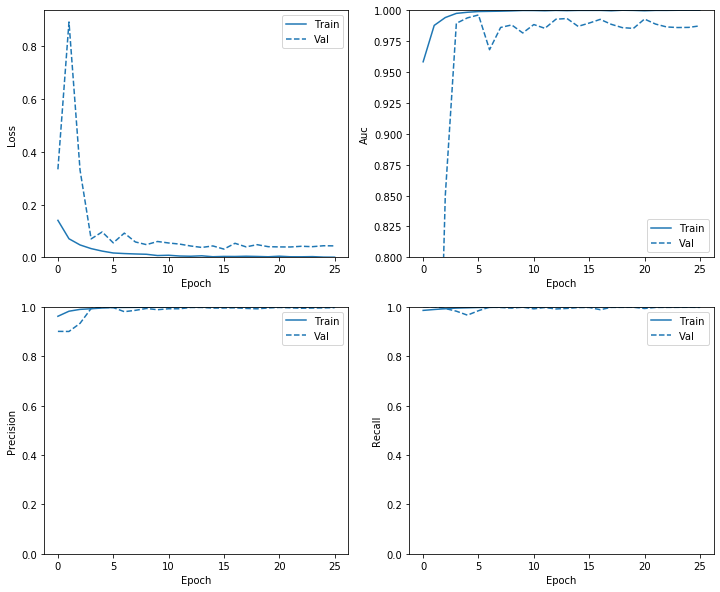

In [23]:
plot_metrics(baseline_history)
plt.savefig(log_dir+"/baseline_metrics_plot")

In [24]:
baseline_results = baseline_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/baseline_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, baseline_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

58/58 - 4s - loss: 0.0327 - tp: 6675.0000 - fp: 35.0000 - tn: 700.0000 - fn: 14.0000 - accuracy: 0.9934 - precision: 0.9948 - recall: 0.9979 - auc: 0.9887

loss : 0.03269147375694643
tp : 6675.0
fp : 35.0
tn : 700.0
fn : 14.0
accuracy : 0.9933997988700867
precision : 0.994783878326416
recall : 0.9979069828987122
auc : 0.9886979460716248



In [25]:
train_labels_baseline, train_predictions_baseline = numpify(train_ds, baseline_model, samples=5000)
val_labels_baseline, val_predictions_baseline = numpify(val_ds, baseline_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  507
Legitimate Lesions Incorrectly Detected (False Positives):  2
Fraudulent Lesions Missed (False Negatives):  2
Fraudulent Lesions Detected (True Positives):  4489
Total Fraudulent Lesions:  4491



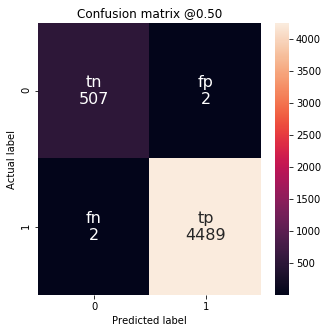

In [26]:
plot_cm(train_labels_baseline, train_predictions_baseline)
plt.savefig(log_dir+"/baseline_cm_plot")

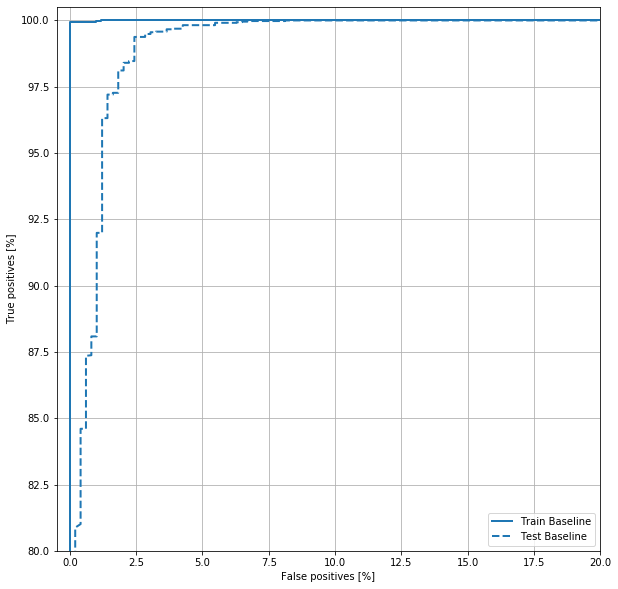

In [27]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/baseline_roc_plot")

### Calculate class weights
See https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [28]:
weight_for_0 = (1/neg)*(total)/2.0
weight_for_1 = (1/pos)*(total)/2.0

class_weight = {0: weight_for_0,
                1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 5.00
Weight for class 1: 0.56


In [29]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_ds,
    steps_per_epoch = train_steps,
    epochs = config["num_epochs"],
    validation_data = test_ds,
    validation_steps = test_steps,
    validation_freq = 1,
    class_weight = class_weight,
    callbacks = callbacks
)

Train for 273 steps, validate for 58 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
273/273 [==============================] - 25s 93ms/step - loss: 0.1664 - tp: 30892.0000 - fp: 1386.0000 - tn: 2107.0000 - fn: 559.0000 - accuracy: 0.9443 - precision: 0.9571 - recall: 0.9822 - auc: 0.9500 - val_loss: 1.4427 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 739.0000 - val_fn: 6685.0000 - val_accuracy: 0.0995 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8401

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008420727945712524.
Epoch 2/100
273/273 [==============================] - 16s 59ms/step - loss: 0.0926 - tp: 31044.0000 - fp: 807.0000 - tn: 2694.0000 - fn: 399.0000 - accuracy: 0.9655 - precision: 0.9747 - recall: 0.9873 - auc: 0.9800 - val_loss: 0.5682 - val_tp: 6681.0000 - val_fp: 743.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.8999 - val_precision: 0.8999 - val_recall: 1.0000 - val_

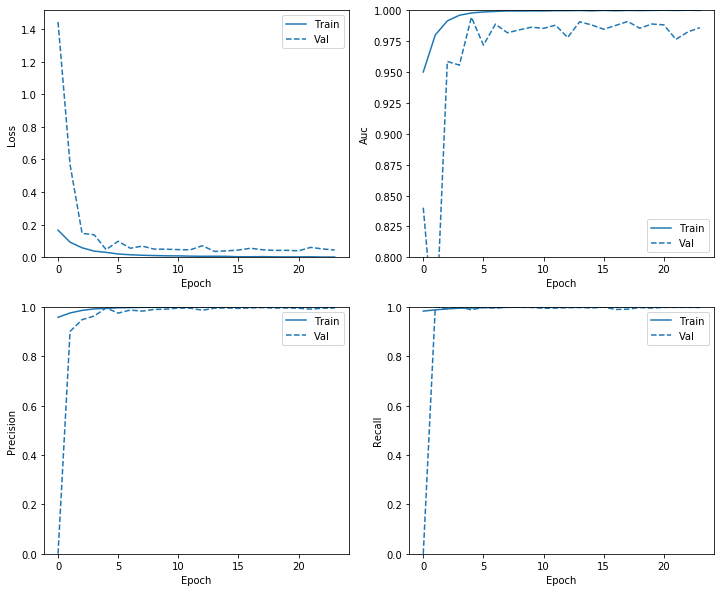

In [30]:
plot_metrics(weighted_history)
plt.savefig(log_dir+"/weighted_metrics_plot")

In [31]:
weighted_results = weighted_model.evaluate(val_ds, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/weighted_val_results.txt","w")
for name, value in zip(baseline_model.metrics_names, weighted_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

58/58 - 1s - loss: 0.0273 - tp: 6674.0000 - fp: 33.0000 - tn: 704.0000 - fn: 13.0000 - accuracy: 0.9938 - precision: 0.9951 - recall: 0.9981 - auc: 0.9908

loss : 0.027321237834634114
tp : 6674.0
fp : 33.0
tn : 704.0
fn : 13.0
accuracy : 0.993803858757019
precision : 0.995079755783081
recall : 0.9980559349060059
auc : 0.9908109903335571



In [32]:
train_labels_weighted, train_predictions_weighted = numpify(train_ds, weighted_model, samples=5000)
val_labels_weighted, val_predictions_weighted = numpify(val_ds, weighted_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  502
Legitimate Lesions Incorrectly Detected (False Positives):  1
Fraudulent Lesions Missed (False Negatives):  1
Fraudulent Lesions Detected (True Positives):  4496
Total Fraudulent Lesions:  4497



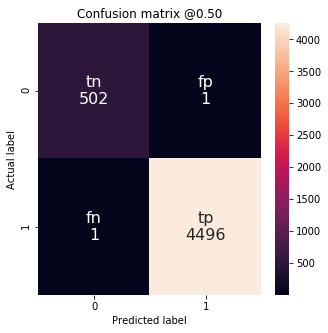

In [33]:
plot_cm(train_labels_weighted, train_predictions_weighted)
plt.savefig(log_dir+"/weighted_cm_plot")

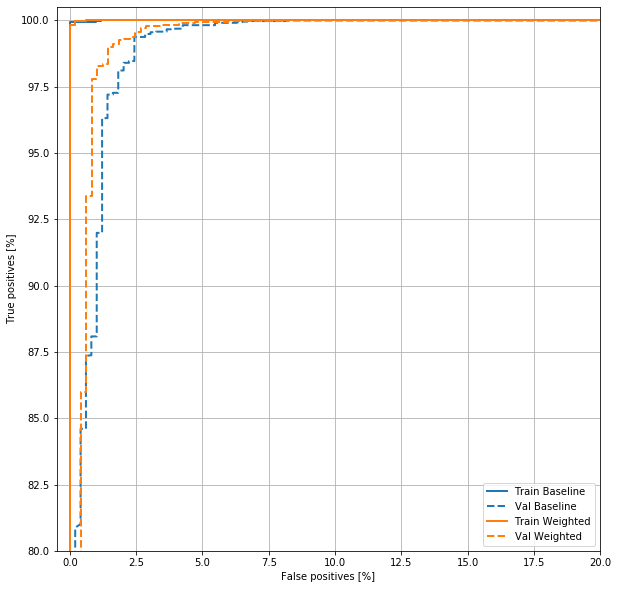

In [34]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/weighted_roc_plot")

## Oversampling the minority class

In [35]:
# Remove the cache
!rm -rf ./cache/*

# Set dataset resample to true to make 5050 distribution of samples
config["resample"] = True

Create training, testing and validation dataset from utils/data_prep.py

In [36]:
train_ds_resampled, test_ds_resampled, val_ds_resampled, params = create_dataset(config)

Negative class names:
        - ship
Positive class names:
        - cat
        - airplane
        - deer
        - automobile
        - horse
        - truck
        - dog
        - bird
        - frog

Negative samples:  5000 | 10.00%
Positive samples: 45000 | 90.00%

Total number of images: 50000
Dataset.list_files:  /mnt/sdb/cifar10/train/*/*.*g 

[1 1 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[0 0 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 0 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 0 1 1 0]
[1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 1 1 1]

Resamplng the dataset..

Fractions:  [0.10263672 0.8973633 ]
Counts:  [1051. 9189.]

[0 0 0 1 0 0 1 0 1 1]
[0 1 0 1 0 1 0 1 1 0]
[0 0 1 0 0 0 1 0 0 0]
[0 1 1 0 1 1 0 1 0 1]
[1 0 0 0 0 1 0 1 1 0]
[1 1 0 0 1 0 0 0 1 0]
[0 0 0 0 0 1 1 1 1 0]
[0 0 1 1 0 1 0 1 1 0]
[0 1 0 1 1 1 1 1 0 0]
[1 1 0 1 1 1 0 0 1 0]


In [37]:
# Check the mean value is close to 0.5
for img, label in train_ds_resampled.take(3):
    print(label.numpy().mean())

0.5078125
0.515625
0.515625


In [38]:
resampled_steps_per_epoch = np.ceil(2.0*neg/config["batch_size"])
print (resampled_steps_per_epoch)

79.0


In [39]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

resampled_history = resampled_model.fit(
    train_ds_resampled,
    steps_per_epoch = resampled_steps_per_epoch,
    epochs = config["num_epochs"],
    validation_data = test_ds_resampled,
    validation_steps = resampled_steps_per_epoch,
    validation_freq = 1,
    callbacks = callbacks
)

Train for 79.0 steps, validate for 79.0 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/100
79/79 [==============================] - 35s 440ms/step - loss: 0.4097 - tp: 4588.0000 - fp: 957.0000 - tn: 4091.0000 - fn: 476.0000 - accuracy: 0.8583 - precision: 0.8274 - recall: 0.9060 - auc: 0.9354 - val_loss: 79.5651 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4954.0000 - val_fn: 5158.0000 - val_accuracy: 0.4899 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0008420727945712524.
Epoch 2/100
79/79 [==============================] - 7s 88ms/step - loss: 0.1683 - tp: 4719.0000 - fp: 365.0000 - tn: 4732.0000 - fn: 296.0000 - accuracy: 0.9346 - precision: 0.9282 - recall: 0.9410 - auc: 0.9825 - val_loss: 1.0968 - val_tp: 5167.0000 - val_fp: 4945.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5110 - val_precision: 0.5110 - val_recall: 1.0000 - val_a

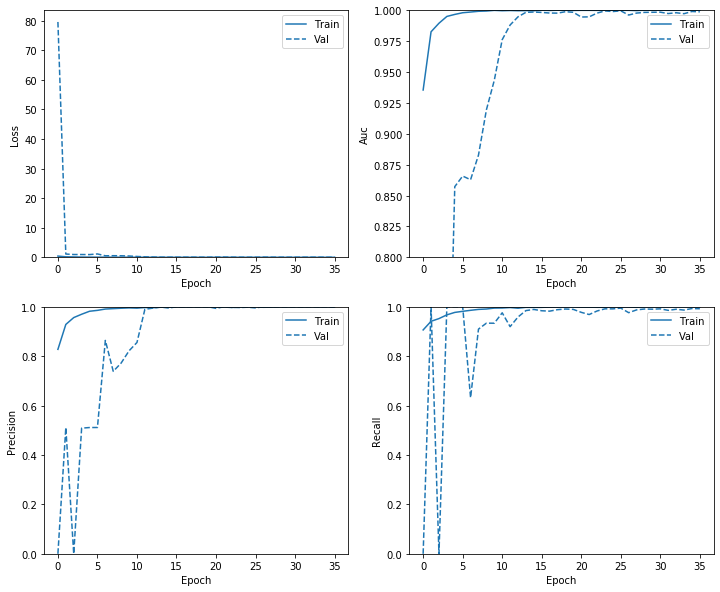

In [40]:
plot_metrics(resampled_history)
plt.savefig(log_dir+"/resampled_metrics_plot")

In [41]:
resampled_results = resampled_model.evaluate(val_ds_resampled, verbose=2, steps=val_steps)
print()

f = open(log_dir+"/resampled_val_results.txt","w")
for name, value in zip(resampled_model.metrics_names, resampled_results):
    line = "{} : {}\n".format(name, value)
    print(line, end='')
    f.write(line)
f.close()
print()

58/58 - 22s - loss: 0.0253 - tp: 3622.0000 - fp: 20.0000 - tn: 3752.0000 - fn: 30.0000 - accuracy: 0.9933 - precision: 0.9945 - recall: 0.9918 - auc: 0.9986

loss : 0.025289362612589874
tp : 3622.0
fp : 20.0
tn : 3752.0
fn : 30.0
accuracy : 0.9932650923728943
precision : 0.9945085048675537
recall : 0.9917853474617004
auc : 0.9985859990119934



In [42]:
train_labels_resampled, train_predictions_resampled = numpify(train_ds_resampled, resampled_model, samples=5000)
val_labels_resampled, val_predictions_resampled = numpify(val_ds, resampled_model, samples=5000)

Legitimate Lesions Detected (True Negatives):  493
Legitimate Lesions Incorrectly Detected (False Positives):  5
Fraudulent Lesions Missed (False Negatives):  19
Fraudulent Lesions Detected (True Positives):  4483
Total Fraudulent Lesions:  4502



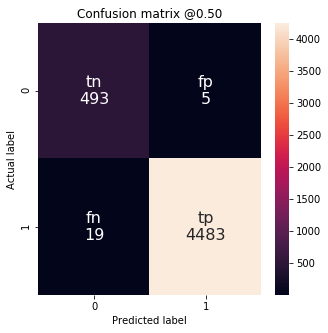

In [43]:
plot_cm(val_labels_resampled, val_predictions_resampled)
plt.savefig(log_dir+"/resampled_cm_plot")

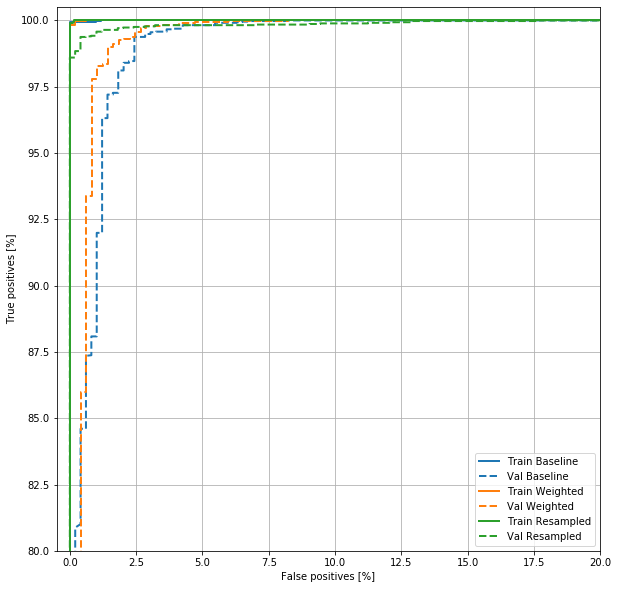

In [44]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Val Baseline", val_labels_baseline, val_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels_weighted, train_predictions_weighted, color=colors[1])
plot_roc("Val Weighted", val_labels_weighted, val_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels_resampled, train_predictions_resampled, color=colors[2])
plot_roc("Val Resampled", val_labels_resampled, val_predictions_resampled, color=colors[2], linestyle='--')

plt.legend(loc='lower right');
plt.savefig(log_dir+"/resampled_roc_plot")

`Tensorboard`

## Predict new samples

In [45]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.9999 | 1.0
Image 24 of 128


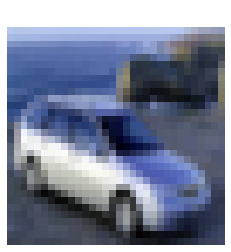

In [46]:
# Get a random image and label
rand = np.random.randint(0, config["batch_size"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resampled_model.predict(np.expand_dims(image, axis=0))[0]
pred = predictions[0]
print("{:0.4f} | {}".format(pred, np.round(pred)))

prediction = ('Boat') if np.round(pred)==0 else ('Not boat')

print ("Image {} of {}".format(rand, config["batch_size"]))

plt.figure(frameon=False, facecolor='white');
plt.title(prediction, fontdict={'color':'white','size':20})
plt.imshow(image)
plt.axis('off');

In [47]:
# Predict one batch
predictions = resampled_model.predict(images)

print ('{:3}  {:5}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -----  ----')

for i, prediction in enumerate(predictions.flat):
    print ('\n{:3}  {:.3f}  {:.3f}'.format(i, labels[i], prediction), end='')
    if (int(labels[i]) != int(np.round(prediction))): print (" -Wrong", end='')

idx  label  pred
---  -----  ----

  0  1.000  1.000
  1  1.000  1.000
  2  1.000  1.000
  3  1.000  1.000
  4  1.000  1.000
  5  1.000  1.000
  6  1.000  1.000
  7  1.000  1.000
  8  1.000  1.000
  9  1.000  1.000
 10  0.000  0.000
 11  1.000  1.000
 12  1.000  1.000
 13  0.000  0.000
 14  1.000  1.000
 15  1.000  1.000
 16  0.000  0.000
 17  1.000  1.000
 18  1.000  1.000
 19  1.000  1.000
 20  1.000  1.000
 21  1.000  1.000
 22  1.000  1.000
 23  1.000  1.000
 24  1.000  1.000
 25  0.000  0.000
 26  1.000  1.000
 27  1.000  1.000
 28  1.000  1.000
 29  1.000  1.000
 30  1.000  1.000
 31  1.000  1.000
 32  1.000  1.000
 33  1.000  1.000
 34  1.000  1.000
 35  1.000  1.000
 36  1.000  1.000
 37  1.000  1.000
 38  1.000  1.000
 39  1.000  1.000
 40  1.000  1.000
 41  1.000  1.000
 42  1.000  1.000
 43  1.000  1.000
 44  1.000  1.000
 45  1.000  1.000
 46  1.000  1.000
 47  1.000  1.000
 48  1.000  1.000
 49  0.000  0.000
 50  1.000  1.000
 51  1.000  1.000
 52  1.000  1.000
 53  1.000 